In [1]:
!pip install stanza

     |████████████████████████████████| 337 kB 6.0 MB/s 


In [2]:
# Upload config.py with API keys
from google.colab import files
uploaded = files.upload()

Saving config.py to config.py


In [3]:
import os
from config import KaggleKey
os.environ['KAGGLE_USERNAME'] = KaggleKey.kaggle_username
os.environ['KAGGLE_KEY'] = KaggleKey.kaggle_key
!kaggle datasets download -d albrace/twitter-data

 99% 770M/779M [00:07<00:00, 95.5MB/s]
100% 779M/779M [00:07<00:00, 114MB/s] 


In [4]:
!unzip /content/twitter-data.zip -d /content/data

Archive:  /content/twitter-data.zip
  inflating: /content/data/2019_all_twitter_data/2019_all_twitter_data.csv  
  inflating: /content/data/bots/bots.csv  
  inflating: /content/data/clean_twitter_data/all_2019.csv  
  inflating: /content/data/clean_twitter_data/all_users.csv  
  inflating: /content/data/clean_twitter_data/pol_actor_users.csv  
  inflating: /content/data/ge2017_cand_data/ge2017_cand_data.csv  
  inflating: /content/data/twitter_data/all_twitter_data.csv  
  inflating: /content/data/twitter_data/political_twitter_data.csv  


In [5]:
import string
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

import nltk
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

import stanza
stanza.download('en')

sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


2021-07-26 14:18:28 INFO: Downloading default packages for language: en (English)...


2021-07-26 14:19:51 INFO: Finished downloading models and saved to /root/stanza_resources.


In [6]:
nlp = stanza.Pipeline('en', processors='tokenize,sentiment')

2021-07-26 14:20:27 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| sentiment | sstplus  |

2021-07-26 14:20:27 INFO: Use device: cpu
2021-07-26 14:20:27 INFO: Loading: tokenize
2021-07-26 14:20:27 INFO: Loading: sentiment
2021-07-26 14:20:28 INFO: Done loading processors!


In [92]:
all_2019_df = pd.read_csv('/content/data/2019_all_twitter_data/2019_all_twitter_data.csv', encoding='cp1252')
score_df = pd.read_csv('/content/botscores.txt', delimiter=',', header=None)
score_df.columns = ['score', 'user']

Text(0.5, 1.0, 'Distribution of Bot Scores')

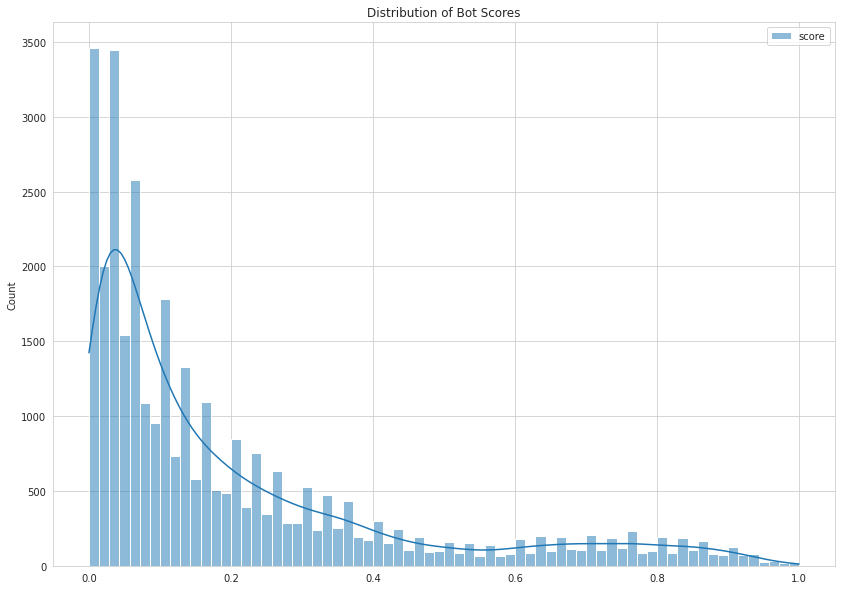

In [33]:
fig, ax = plt.subplots(figsize=(14,10))
sns.histplot(data=score_df, kde=True)
ax.set_title('Distribution of Bot Scores')

In [93]:
all_2019_df = pd.merge(left=score_df, right=all_2019_df, left_on='user', right_on='quotedTweet_username')
all_2019_df = all_2019_df.drop(columns=['user'])

In [94]:
bot_df = all_2019_df[~(all_2019_df['score'] < 0.87)]

In [95]:
bot_df

,score,tweet_date,tweet_content,tweet_id,tweet_likes,tweet_replies,tweet_retweets,tweet_quotes,user_username,user_id,user_followers,user_friends,user_statuses,user_verified,user_url,tweet_url,mentioned_users,quotedTweet_id,quotedTweet_content,quotedTweet_username,quotedTweet_userID,quotedTweet_mentionedUsers
126299,0.88,2019-12-12 21:31:57+00:00,"b""After more than 30 yrs paying tax, when I wa...",1205238885808254977,2,0,1,0,EvadneyC,176166517,2523,1751,15525,False,https://twitter.com/EvadneyC,https://twitter.com/EvadneyC/status/1205238885...,NaN,1.205117e+18,b'DISGUSTING: Man is given just \xc2\xa37 in U...,pauldashworth,2.591720e+09,NaN
126300,0.88,2019-12-12 21:21:19+00:00,b'#stillTime to #saveourNHS https://t.co/VmSJx...,1205236210479828992,1,0,0,0,vicofstswithuns,277624909,665,640,21987,False,https://twitter.com/vicofstswithuns,https://twitter.com/vicofstswithuns/status/120...,NaN,1.205117e+18,b'STARS FOR LABOUR: The biggest names in showb...,pauldashworth,2.591720e+09,NaN
126301,0.88,2019-12-12 19:29:22+00:00,b'\xf0\x9f\x98\xa1\n#GE2019 https://t.co/qxjvU...,1205208036245151745,1,0,2,0,Gill_666,212628855,2216,2482,28455,False,https://twitter.com/Gill_666,https://twitter.com/Gill_666/status/1205208036...,NaN,1.205117e+18,b'DISGUSTING: Man is given just \xc2\xa37 in U...,pauldashworth,2.591720e+09,NaN
126302,0.88,2019-12-12 19:28:41+00:00,b'Blind sided Boris... \xf0\x9f\x8c\xb9\n\nWat...,1205207864853352450,0,0,0,0,SirClouseau,1199334401349476353,131,687,5743,False,https://twitter.com/SirClouseau,https://twitter.com/SirClouseau/status/1205207...,NaN,1.205153e+18,"b'To save our #NHS, to protect public services...",pauldashworth,2.591720e+09,NaN
126303,0.88,2019-12-12 19:01:55+00:00,b'#SaveOurNHS #VoteTactically #GeneralElection...,1205201128343949313,1,0,0,0,Socialistdawn,221310328,11354,10328,225026,False,https://twitter.com/Socialistdawn,https://twitter.com/Socialistdawn/status/12052...,NaN,1.205153e+18,"b'To save our #NHS, to protect public services...",pauldashworth,2.591720e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255097,0.89,2019-11-23 14:47:14+00:00,"b""But when I'm in power I will do exactly what...",1198251666895712259,2,1,0,0,SLOTE3,1387392716,3117,2907,53811,False,https://twitter.com/SLOTE3,https://twitter.com/SLOTE3/status/119825166689...,NaN,1.198250e+18,b'There is a snag with Corbyn\xe2\x80\x99s sta...,Gemac91138162,1.086001e+18,NaN
255163,0.87,2019-11-25 12:47:36+00:00,b'At least the spending on EV infrastructure m...,1198946334860021760,0,0,0,0,GraniteSharesUK,1142048307566583808,199,288,920,False,https://twitter.com/GraniteSharesUK,https://twitter.com/GraniteSharesUK/status/119...,NaN,1.198930e+18,b'The \xc2\xa33bn hole in the Tory manifesto h...,FTAlphaville,1.446564e+07,NaN
255180,0.92,2019-12-12 23:12:17+00:00,b'#GE19 for those not liking the projected out...,1205264138408099840,0,0,0,0,NickPfitzner,309526317,665,701,40657,False,https://twitter.com/NickPfitzner,https://twitter.com/NickPfitzner/status/120526...,NaN,1.205261e+18,b'https://t.co/ICQG0iU5lS',heelersbot,7.272298e+17,NaN
255226,0.95,2019-11-15 17:23:12+00:00,b'Every time I see a tweet that corbyns an IRA...,1195391816130072576,0,0,0,0,JMAG1892_2,1173998229148569601,94,348,5586,False,https://twitter.com/JMAG1892_2,https://twitter.com/JMAG1892_2/status/11953918...,NaN,1.195009e+18,b'https://t.co/iaG6G3WJrR',binksOutContext,1.195008e+18,NaN


In [96]:
len(bot_df['quotedTweet_username'].unique())

615

In [68]:
print(bot_df.shape)
bot_df.isnull().sum()

(2895, 22)


score                            0
tweet_date                       0
tweet_content                    0
tweet_id                         0
tweet_likes                      0
tweet_replies                    0
tweet_retweets                   0
tweet_quotes                     0
user_username                    0
user_id                          0
user_followers                   0
user_friends                     0
user_statuses                    0
user_verified                    0
user_url                         0
tweet_url                        0
mentioned_users               2315
quotedTweet_id                   0
quotedTweet_content              0
quotedTweet_username             0
quotedTweet_userID               0
quotedTweet_mentionedUsers    2384
dtype: int64

In [97]:
bot_df['tweet_date'] = bot_df['tweet_date'].map(lambda x: str(x)[:-15])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [98]:
bot_df['tweet_date'] = pd.to_datetime(bot_df['tweet_date'])
bot_df = bot_df[~(bot_df['tweet_date'] < '2019-11-06')]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [99]:
punc = list(string.punctuation)
stop = stopwords.words('english') + punc + ['rt', 'via']

tt = TweetTokenizer()

In [47]:
def hashtag_extract(s):
  hashtags = []
  for i in s:
    ht = re.findall(r"#(\w+)", i)
    hashtags.append(ht)
  return hashtags

In [48]:
def fix_encode(df):
  df['tweet_content'] = df['tweet_content'].str.replace('&amp', '&')
  df['tweet_content'] = df['tweet_content'].str.replace('b"', '')
  df['tweet_content'] = df['tweet_content'].str.replace("b'", '')
  return df

In [49]:
def join_punct(s):
    return ''.join(ch for ch in s if ch not in punc)

In [50]:
def remove_emoji(s):
    emoji_pattern = re.compile(
        r'(\u00a9|\u00ae|[\u2000-\u3300]|\ud83c[\ud000-\udfff]|\ud83d[\ud000-\udfff]|\ud83e[\ud000-\udfff]|(?:\U0001f92d))',
        re.UNICODE)
    return emoji_pattern.sub(r'', s)

In [51]:
def remove_url(s):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    no_url = url_pattern.sub(r'', s)
    return no_url

In [52]:
def clean_tweet(s):
  clean_tweets = []
  for i in s:
    tweet_token = tt.tokenize(join_punct(remove_emoji(remove_url(i.lower()))))
    no_stop_words = [token for token in tweet_token if not token in stop]
    clean_tweets.append(no_stop_words)
  return clean_tweets

In [53]:
def preprocessing_user(df):

  df['mentioned_users']=df['mentioned_users'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['mentioned_users']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['mentioned_users'])
  df['mentioned_users'] = mentioned_user
  df['mentioned_users'] = df['mentioned_users'].apply(lambda x: np.nan if len(x)==0 else x)

  df['quotedTweet_mentionedUsers']=df['quotedTweet_mentionedUsers'].fillna("")
  mentioned_user = []
  for i, user in enumerate(df['quotedTweet_mentionedUsers']):
    usernames = user.split("username='")
    username_list = []
    for username in usernames:
      username_list.append(re.findall("^(.+?)'", username))
    mentioned_user.append(username_list[1:])
  df = df.drop(columns=['quotedTweet_mentionedUsers'])
  df['quotedTweet_mentionedUsers'] = mentioned_user
  df['quotedTweet_mentionedUsers'] = df['quotedTweet_mentionedUsers'].apply(lambda x: np.nan if len(x)==0 else x)

  return df

In [54]:
def clean_sentiment(s):
  clean_tweets = []
  for i in s:
    x = join_punct(remove_url(i.lower()))
    clean_tweets.append(x)
  return clean_tweets

In [75]:
def sentiment(df, col):
  rows = []
  for tweet in df[col]:
    doc = nlp(tweet)
    for sentence in doc.sentences:
      row={
          'text_'+col: sentence.text,
          'sentiment_'+col: sentence.sentiment
      }
    rows.append(row)
  return pd.DataFrame(rows)

In [100]:
bot_df = fix_encode(bot_df)
bot_df['hashtags'] = hashtag_extract(bot_df['tweet_content'])
bot_df['quoted_hashtags'] = hashtag_extract(bot_df['quotedTweet_content'])
bot_df['clean_tweet_content'] = clean_tweet(bot_df['tweet_content'])
bot_df['clean_quotedTweet_content'] = clean_tweet(bot_df['quotedTweet_content'])
bot_df = preprocessing_user(bot_df)
# bot_df['clean_sentiment_content'] = clean_sentiment(bot_df['tweet_content'])
# bot_df['clean_sentiment_quoted'] = clean_sentiment(bot_df['quotedTweet_content'])
# sentiment_2019_df = sentiment(bot_df, 'clean_sentiment_content')
# all_2019_sent_df=sentiment_2019_df.merge(right=bot_df, left_on='text_clean_sentiment_content', right_on='clean_sentiment_content')
# sentiment_2019_quoted_df = sentiment(bot_df, 'clean_sentiment_quoted')
# final_df=sentiment_2019_quoted_df.merge(right=all_2019_sent_df, left_on='text_clean_sentiment_quoted', right_on='clean_sentiment_quoted')
# final_df = final_df.drop(columns=['text_clean_sentiment_quoted', 'text_clean_sentiment_content', 'clean_sentiment_content', 'clean_sentiment_quoted'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [102]:
bot_df

,score,tweet_date,tweet_content,tweet_id,tweet_likes,tweet_replies,tweet_retweets,tweet_quotes,user_username,user_id,user_followers,user_friends,user_statuses,user_verified,user_url,tweet_url,quotedTweet_id,quotedTweet_content,quotedTweet_username,quotedTweet_userID,hashtags,quoted_hashtags,clean_tweet_content,clean_quotedTweet_content,mentioned_users,quotedTweet_mentionedUsers
126299,0.88,2019-12-12,"After more than 30 yrs paying tax, when I was ...",1205238885808254977,2,0,1,0,EvadneyC,176166517,2523,1751,15525,False,https://twitter.com/EvadneyC,https://twitter.com/EvadneyC/status/1205238885...,1.205117e+18,b'DISGUSTING: Man is given just \xc2\xa37 in U...,pauldashworth,2.591720e+09,[GE2019],"[GE2019, UKElection, BorisOut, ToriesOut, Tact...","[30, yrs, paying, tax, diagnosed, cancer, 2, y...","[bdisgusting, man, given, xc2xa37, universal, ...",NaN,NaN
126300,0.88,2019-12-12,#stillTime to #saveourNHS https://t.co/VmSJx2J...,1205236210479828992,1,0,0,0,vicofstswithuns,277624909,665,640,21987,False,https://twitter.com/vicofstswithuns,https://twitter.com/vicofstswithuns/status/120...,1.205117e+18,b'STARS FOR LABOUR: The biggest names in showb...,pauldashworth,2.591720e+09,"[stillTime, saveourNHS]","[GE2019, UKElection, BorisOut, ToriesOut, Tact...","[stilltime, saveournhs]","[bstars, labour, biggest, names, showbiz, voti...",NaN,NaN
126301,0.88,2019-12-12,\xf0\x9f\x98\xa1\n#GE2019 https://t.co/qxjvUS2...,1205208036245151745,1,0,2,0,Gill_666,212628855,2216,2482,28455,False,https://twitter.com/Gill_666,https://twitter.com/Gill_666/status/1205208036...,1.205117e+18,b'DISGUSTING: Man is given just \xc2\xa37 in U...,pauldashworth,2.591720e+09,[GE2019],"[GE2019, UKElection, BorisOut, ToriesOut, Tact...",[xf0x9fx98xa1nge2019],"[bdisgusting, man, given, xc2xa37, universal, ...",NaN,NaN
126302,0.88,2019-12-12,Blind sided Boris... \xf0\x9f\x8c\xb9\n\nWatch...,1205207864853352450,0,0,0,0,SirClouseau,1199334401349476353,131,687,5743,False,https://twitter.com/SirClouseau,https://twitter.com/SirClouseau/status/1205207...,1.205153e+18,"b'To save our #NHS, to protect public services...",pauldashworth,2.591720e+09,"[VoteLabourToday, VotingLabour, GE2019, YouthQ...","[NHS, Tory, GE2019, UKElection, BorisOut, Tori...","[blind, sided, boris, xf0x9fx8cxb9nnwatch, lik...","[bto, save, nhs, protect, public, services, co...",NaN,NaN
126303,0.88,2019-12-12,#SaveOurNHS #VoteTactically #GeneralElection20...,1205201128343949313,1,0,0,0,Socialistdawn,221310328,11354,10328,225026,False,https://twitter.com/Socialistdawn,https://twitter.com/Socialistdawn/status/12052...,1.205153e+18,"b'To save our #NHS, to protect public services...",pauldashworth,2.591720e+09,"[SaveOurNHS, VoteTactically, GeneralElection2019]","[NHS, Tory, GE2019, UKElection, BorisOut, Tori...","[saveournhs, votetactically, generalelection, ...","[bto, save, nhs, protect, public, services, co...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255097,0.89,2019-11-23,But when I'm in power I will do exactly what M...,1198251666895712259,2,1,0,0,SLOTE3,1387392716,3117,2907,53811,False,https://twitter.com/SLOTE3,https://twitter.com/SLOTE3/status/119825166689...,1.198250e+18,b'There is a snag with Corbyn\xe2\x80\x99s sta...,Gemac91138162,1.086001e+18,[Corbyn],[],"[im, power, exactly, momentum, want, ill, revo...","[bthere, snag, corbynxe, 2x80x99s, stance, bre...",NaN,NaN
255163,0.87,2019-11-25,At least the spending on EV infrastructure may...,1198946334860021760,0,0,0,0,GraniteSharesUK,1142048307566583808,199,288,920,False,https://twitter.com/GraniteSharesUK,https://twitter.com/GraniteSharesUK/status/119...,1.198930e+18,b'The \xc2\xa33bn hole in the Tory manifesto h...,FTAlphaville,1.446564e+07,"[EV, techdisruption, GE2019]",[],"[least, spending, ev, infrastructure, may, rea...","[bthe, xc2xa33bn, hole, tory, manifesto]",NaN,NaN
255180,0.92,2019-12-12,#GE19 for those not liking the projected outco...,1205264138408099840,0,0,0,0,

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.histplot(data=all_2019_sent_df, x='tweet_date')
plt.setp(g.get_xticklabels(), rotation=45)
plt.show()

In [103]:
!mkdir output

In [106]:
bot_df.to_csv('output/bot_df.csv')

In [ ]:
cand_sent_df.to_csv('output/pol_actor_users.csv')
all_sent_df.to_csv('output/all_users.csv')

In [ ]:
!zip -r /content/output.zip /content/output

  adding: content/output/ (stored 0%)
  adding: content/output/all_users.csv (deflated 83%)
  adding: content/output/pol_actor_users.csv (deflated 87%)
